In [1]:
import torch.nn as nn
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import json
from scipy.interpolate import InterpolatedUnivariateSpline
from torch.utils.data import Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support, accuracy_score, f1_score
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
# --------------------------
# 1. PREPROCESSING FUNCTION
# --------------------------
def camera2model(img, return_transform=False, target_size=(128, 128)):
    assert img.shape == (874, 1164, 3)
    
    y_start, y_end = 200, 220
    x_start, x_end = 106, 106

    cropped = img[y_start:-y_end, x_start:-x_end]
    resized = cv2.resize(cropped, target_size)

    if return_transform:
        scale_x = target_size[0] / (1164 - x_start - x_end)
        scale_y = target_size[1] / (874 - y_start - y_end)
        return resized, (x_start, y_start, scale_x, scale_y)
    return resized


def read_content_raw(xml_file: str, transform_params=None):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_left, list_right = [], []
    
    x_offset, y_offset, scale_x, scale_y = transform_params or (0, 0, 1, 1)

    for boxes in root.iter('object'):
        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        xmin = (xmin - x_offset) * scale_x
        ymin = (ymin - y_offset) * scale_y
        xmax = (xmax - x_offset) * scale_x
        ymax = (ymax - y_offset) * scale_y
        
        center = np.array([(xmin + xmax) / 2, (ymin + ymax) / 2]).astype(int)

        name = boxes.find("name").text
        if name == 'l':
            list_left.append(center)
        elif name == 'r':
            list_right.append(center)
        else:
            raise ValueError(f'Invalid label: {name}')
            
    return {'left': np.stack(list_left), 'right': np.stack(list_right)}


def prepare_masks(lane_points, img_size=(720, 120)):
    left_mask = np.zeros(img_size[::-1], dtype=np.float32)
    right_mask = np.zeros(img_size[::-1], dtype=np.float32)

    if len(lane_points['left']) > 0:
        for i in range(len(lane_points['left']) - 1):
            cv2.line(left_mask,
                     tuple(lane_points['left'][i]),
                     tuple(lane_points['left'][i + 1]),
                     1, thickness=3)

    if len(lane_points['right']) > 0:
        for i in range(len(lane_points['right']) - 1):
            cv2.line(right_mask,
                     tuple(lane_points['right'][i]),
                     tuple(lane_points['right'][i + 1]),
                     1, thickness=3)
                     
    return np.stack([left_mask, right_mask], axis=0)


def preprocess_and_save(data_dir, output_dir, max_scenes=20, max_frames=50, target_size=(128, 128)):
    os.makedirs(output_dir, exist_ok=True)
    metadata = []
    
    for scene_num in tqdm(range(1, max_scenes + 1)):
        scene_path = os.path.join(data_dir, f"scb{scene_num}")
        if not os.path.exists(scene_path):
            continue
            
        for frame in range(max_frames):
            img_path = os.path.join(scene_path, "imgs", f"{frame}.png")
            if not os.path.exists(img_path):
                continue
                
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            img, transform = camera2model(img, return_transform=True, target_size=target_size)

            xml_path = os.path.join(scene_path, f"{frame}.xml")
            if not os.path.exists(xml_path):
                continue

            lane_points = read_content_raw(xml_path, transform_params=transform)
            mask = prepare_masks(lane_points, img_size=target_size)

            scene_out_dir = os.path.join(output_dir, f"scb{scene_num}")
            os.makedirs(scene_out_dir, exist_ok=True)

            img_out_path = os.path.join(scene_out_dir, f"{frame}_img.npy")
            mask_out_path = os.path.join(scene_out_dir, f"{frame}_mask.npy")

            np.save(img_out_path, img)
            np.save(mask_out_path, mask)

            metadata.append({
                'image': img_out_path,
                'mask': mask_out_path
            })
    
    return metadata


# --------------------------
# 2. CONVERT TO TUSIMPLE FORMAT (FIXED)
# --------------------------
def interpolate_lane(points, y_all):
    if len(points) <= 1:
        return np.full_like(y_all, -2)

    # Sort and deduplicate by y
    idx = np.argsort(points[:, 1])
    sorted_points = points[idx]
    unique_y, unique_idx = np.unique(sorted_points[:, 1], return_index=True)
    unique_x = sorted_points[:, 0][unique_idx]

    if len(unique_y) <= 1:
        return np.full_like(y_all, -2)

    cs = InterpolatedUnivariateSpline(unique_y, unique_x, k=1)
    interp_x = cs(y_all)
    interp_x = np.where((interp_x < 0) | (interp_x > 1279), -2, interp_x)
    return interp_x.astype(int)


def generate_tusimple_annotations(image_dir, output_json):
    map_anno = {}
    
    for sc in tqdm(range(1, 101)):
        path = f'{image_dir}/scb{sc}/'
        for frame in range(21):
            img_path = path + f"imgs/{frame}.png"
            if not os.path.exists(img_path):
                continue
            img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
            img, transform = camera2model(img, return_transform=True)
            
            xml_path = path + f'{frame}.xml'
            if not os.path.exists(xml_path):
                continue
            
            anno = read_content_raw(xml_path, transform_params=transform)
            left = anno['left']
            right = anno['right']

            y_all = np.arange(160, 711, 10)

            lx = interpolate_lane(left, y_all)
            rx = interpolate_lane(right, y_all)

            map_anno[img_path] = {
                'lanes': [lx.tolist(), rx.tolist()],
                'h_samples': y_all.tolist(),
                'raw_file': img_path
            }
            
            # Optional visual inspection
            if sc == 1 and frame == 0:
                plt.figure(figsize=(15, 5))
                
                plt.subplot(1, 3, 1)
                plt.imshow(img)
                if len(left) > 0:
                    plt.scatter(left[:, 0], left[:, 1], c='red', label='Left Lane')
                if len(right) > 0:
                    plt.scatter(right[:, 0], right[:, 1], c='blue', label='Right Lane')
                plt.title("Original Image with Lane Points")
                plt.legend()
                
                plt.subplot(1, 3, 2)
                plt.imshow(img)
                plt.scatter(lx[lx != -2], y_all[lx != -2], c='red')
                plt.scatter(rx[rx != -2], y_all[rx != -2], c='blue')
                plt.title("Interpolated Lanes")
                
                mask = prepare_masks(anno)
                overlay = img.copy()
                overlay[mask[0] > 0] = [255, 0, 0]
                overlay[mask[1] > 0] = [0, 0, 255]
                plt.subplot(1, 3, 3)
                plt.imshow(overlay)
                plt.title("Lane Overlay")
                plt.tight_layout()
                plt.show()

    with open(output_json, 'w') as f:
        json.dump(map_anno, f)
    print(f"✅ Generated TuSimple annotations at {output_json}")


# # --------------------------
# # 3. MAIN FUNCTION
# # --------------------------
# if __name__ == "__main__":
#     image_dir = "../input/comma2k19-ld"
#     output_json = "comma2k19ld_tusimple_annotation.json"
#     generate_tusimple_annotations(image_dir, output_json)


In [12]:
# --------------------------
# 2. DATASET AND MODEL
# --------------------------
class LaneDataset(Dataset):
    def __init__(self, metadata, inject_prob=0.0, transform=None):
        self.metadata = metadata
        self.inject_prob = inject_prob
        self.transform = transform
        
    def __len__(self):
        return len(self.metadata)
    
    def __getitem__(self, idx):
        data = self.metadata[idx]
        image = np.load(data['image']).astype(np.float32) / 255.0
        mask = np.load(data['mask']).astype(np.float32)

        if np.random.rand() < self.inject_prob:
            mode = np.random.choice(['left', 'right'])
            image, mask = inject_anomaly(image, mask, mode=mode)
        else:
            # Gabungkan lane kiri dan kanan → channel 0 = normal
            normal_mask = np.clip(mask[0] + mask[1], 0, 1)
            anomaly_mask = np.zeros_like(normal_mask)
            
            mask = np.stack([normal_mask, anomaly_mask], axis=0)  # [2, H, W]

        image = torch.from_numpy(image).permute(2, 0, 1)
        mask = torch.from_numpy(mask)

        mask = F.interpolate(mask.unsqueeze(0), size=(128, 128), mode='nearest').squeeze(0)

        if self.transform:
            image = self.transform(image)

        return image, mask

import torch
import torch.nn as nn
import torch.nn.functional as F

class LaneDetector(nn.Module):
    def __init__(self):
        super(LaneDetector, self).__init__()
        
        # Encoder Path
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Bridge (Bottleneck)
        self.bridge = nn.Sequential(
            nn.Conv2d(512, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.GELU(),
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.GELU(),
            nn.MaxPool2d(2, ceil_mode=True)
        )

        # Bottleneck Cross-Attention (PERBAIKAN DI SINI)
        self.bottleneck_attn = CrossAttention(
            in_channels_query=1024,
            in_channels_key=512,  # DIUBAH: 256 → 512
            embed_dim=512,
            num_heads=8
        )

        # Decoder Path (tetap sama)
        self.up1 = DecoderBlock(1024, 512, 512)
        self.up2 = DecoderBlock(512, 256, 256)
        self.up3 = DecoderBlock(256, 128, 128)
        self.up4 = DecoderBlock(128, 64, 64)

        # Output Layer
        self.out = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.Conv2d(32, 2, 1)
        )

    def conv_block(self, in_c, out_c):
        return nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.GELU(),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.GELU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        # Encoder path
        e1 = self.enc1(x)   # 1/2 [N, 64, H/2, W/2]
        e2 = self.enc2(e1)  # 1/4 [N, 128, H/4, W/4]
        e3 = self.enc3(e2)  # 1/8 [N, 256, H/8, W/8]
        e4 = self.enc4(e3)  # 1/16 [N, 512, H/16, W/16]
        
        # Bridge (Bottleneck)
        b = self.bridge(e4)  # 1/32 [N, 1024, H/32, W/32]
        
        # Bottleneck Cross-Attention (Diperbaiki)
        b_attn = self.bottleneck_attn(b, e4, e4)  # [N, 1024, H/32, W/32]
        
        # Decoder path dengan multi-level cross-attention
        d1 = self.up1(b_attn, e4)  # [N, 512, H/16, W/16]
        d2 = self.up2(d1, e3)      # [N, 256, H/8, W/8]
        d3 = self.up3(d2, e2)      # [N, 128, H/4, W/4]
        d4 = self.up4(d3, e1)      # [N, 64, H/2, W/2]
        
        # Upsample ke resolusi input
        output = F.interpolate(d4, scale_factor=2, mode='bilinear', align_corners=False)  # [N, 64, H, W]
        output = self.out(output)  # [N, 2, H, W]
        
        return output


# ========== MODUL DIPERBAIKI ========== #

class DecoderBlock(nn.Module):
    """Decoder block dengan cross-attention"""
    def __init__(self, in_c, skip_c, out_c, embed_dim=256, num_heads=8):
        super().__init__()
        
        # Upsampling
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.GELU()
        )
        
        # Cross-Attention dengan skip connection
        self.attn = CrossAttention(
            in_channels_query=out_c,
            in_channels_key=skip_c,
            embed_dim=embed_dim,
            num_heads=num_heads
        )
        
        # Post-attention convolution
        self.conv = nn.Sequential(
            nn.Conv2d(out_c + skip_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.GELU(),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.GELU()
        )
    
    def forward(self, x, skip):
        # Upsample feature map
        x_up = self.up(x)
        
        # Cross-attention antara upsampled features dan skip connection
        attn_out = self.attn(x_up, skip, skip)
        
        # Gabungkan dengan skip connection
        x_cat = torch.cat([attn_out, skip], dim=1)
        
        # Konvolusi akhir
        return self.conv(x_cat)

class CrossAttention(nn.Module):
    """Enhanced Cross-Attention Mechanism (fixed to use nn.MultiheadAttention)"""
    def __init__(self, in_channels_query, in_channels_key, embed_dim, num_heads):
        super().__init__()
        
        # Query projection with normalization
        self.query_conv = nn.Sequential(
            nn.Conv2d(in_channels_query, embed_dim, 1),
            nn.BatchNorm2d(embed_dim),
            nn.GELU()
        )
        
        # Key projection
        self.key_conv = nn.Sequential(
            nn.Conv2d(in_channels_key, embed_dim, 1),
            nn.BatchNorm2d(embed_dim),
            nn.GELU()
        )
        
        # Value projection
        self.value_conv = nn.Sequential(
            nn.Conv2d(in_channels_key, embed_dim, 1),
            nn.BatchNorm2d(embed_dim),
            nn.GELU()
        )
        
        # Use nn.MultiheadAttention via the nn prefix
        # Note: MultiheadAttention expects (S, N, E) input if batch_first=False
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=False
        )
        
        # Output projection
        self.out_conv = nn.Sequential(
            nn.Conv2d(embed_dim, in_channels_query, 1),
            nn.BatchNorm2d(in_channels_query),
            nn.GELU()
        )
        
        # Residual connection and scaling
        self.residual = nn.Identity()
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, query, key, value):
        # Projections: [N, C, H, W] -> projected [N, embed_dim, H, W]
        q = self.query_conv(query)
        k = self.key_conv(key)
        v = self.value_conv(value)
        
        N, Cq, H_q, W_q = q.shape
        _, Ck, H_k, W_k = k.shape  # underscore for N as same batch dim
        
        # flatten spatial dims and permute to MultiheadAttention expected shape
        # from [N, C, H, W] -> [S, N, C] where S = H*W
        q_flat = q.view(N, Cq, -1).permute(2, 0, 1)  # [S_q, N, embed_dim]
        k_flat = k.view(N, Ck, -1).permute(2, 0, 1)  # [S_k, N, embed_dim]
        v_flat = v.view(N, Ck, -1).permute(2, 0, 1)  # [S_v, N, embed_dim]
        
        # Compute attention (attn returns [S_q, N, embed_dim])
        attn_output, _ = self.attn(
            query=q_flat,
            key=k_flat,
            value=v_flat,
            need_weights=False
        )
        
        # reshape back to [N, embed_dim, H_q, W_q]
        attn_output = attn_output.permute(1, 2, 0).contiguous()  # [N, embed_dim, S_q]
        attn_output = attn_output.view(N, -1, H_q, W_q)  # [N, embed_dim, H_q, W_q]
        
        # project and residual
        attn_output = self.out_conv(attn_output)
        return self.residual(query) + self.gamma * attn_output

In [13]:
# --------------------------
# 3. TRAINING WITH METRICS
# --------------------------
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001, optimizer=None, scheduler=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Initialize optimizer if not passed
    if optimizer is None:
        optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define loss function
    criterion = nn.BCEWithLogitsLoss()

    best_val_loss = float('inf')
    history = {
        'train_loss': [], 
        'val_loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': [],
        'iou': []
    }

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]"):
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)

        # Validation phase
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []
        y_true = []
        y_pred = []

        with torch.no_grad():
            for images, masks in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]"):
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item() * images.size(0)

                preds = (outputs > 0.5).float()
                all_preds.append(preds.cpu())
                all_targets.append(masks.cpu())

                for pred_mask, true_mask in zip(preds, masks):
                    pred_anomaly = (pred_mask[1] > 0).any().item()
                    true_anomaly = (true_mask[1] > 0).any().item()
                    y_true.append(true_anomaly)
                    y_pred.append(pred_anomaly)

        # Calculate losses
        train_loss = train_loss / len(train_loader.dataset)
        val_loss = val_loss / len(val_loader.dataset)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        # Calculate metrics (per-pixel)
        all_preds_tensor = torch.cat(all_preds)
        all_targets_tensor = torch.cat(all_targets)
        accuracy, precision, recall, f1, iou = calculate_metrics(all_preds_tensor, all_targets_tensor)

        history['accuracy'].append(accuracy)
        history['precision'].append(precision)
        history['recall'].append(recall)
        history['f1'].append(f1)
        history['iou'].append(iou)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
        print(f"F1-Score: {f1:.4f} | IoU: {iou:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print("Saved best model")

        # Step the scheduler at the end of each epoch
        if scheduler:
            scheduler.step()
            print(f"Learning rate: {scheduler.get_lr()[0]:.6f}")

    # Plot training history
    plot_training_history(history)

    # Generate and plot image-level confusion matrix
    plot_image_confusion_matrix(y_true, y_pred)

    return model

def calculate_metrics(preds, targets):
    # ambil class prediction dari 3 channel (output 3 kelas: bg, normal, anomaly)
    preds_labels = torch.argmax(preds, dim=1).view(-1).cpu().numpy()
    targets_labels = torch.argmax(targets, dim=1).view(-1).cpu().numpy()

    # Accuracy
    accuracy = np.mean(preds_labels == targets_labels)

    # Precision, Recall, F1
    precision, recall, f1, _ = precision_recall_fscore_support(
        targets_labels, preds_labels, average='macro', zero_division=0
    )

    # IoU hanya untuk class != 0 (bg)
    intersection = np.logical_and(targets_labels == preds_labels, targets_labels != 0).sum()
    union = np.logical_or(targets_labels != 0, preds_labels != 0).sum()
    iou = intersection / union if union != 0 else 0.0

    return accuracy, precision, recall, f1, iou


def plot_training_history(history):
    """Plot training history including metrics"""
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(history['accuracy'], label='Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.plot(history['precision'], label='Precision')
    plt.plot(history['recall'], label='Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.title('Precision and Recall')
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.plot(history['f1'], label='F1-Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1-Score')
    plt.title('Validation F1-Score')
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.plot(history['iou'], label='IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title('Validation IoU (Jaccard Index)')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    plt.show()

def plot_image_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Image-level)')
    plt.savefig('image_confusion_matrix.png')
    plt.show()


In [14]:
def inject_anomaly(frame_np, mask_np, mode='left', shift_pixels=20):
    frame = frame_np.copy()
    h, w, _ = frame.shape
    anomaly_mask = np.zeros_like(mask_np[0])

    if mode == 'left':
        frame[:, :-shift_pixels] = frame[:, shift_pixels:]
        frame[:, -shift_pixels:] = 0
        anomaly_mask[:, -shift_pixels:] = 1
    elif mode == 'right':
        frame[:, shift_pixels:] = frame[:, :-shift_pixels]
        frame[:, :shift_pixels] = 0
        anomaly_mask[:, :shift_pixels] = 1
    else:
        raise ValueError("Mode must be 'left' or 'right'")

    normal_mask = np.clip(mask_np[0] + mask_np[1], 0, 1)
    mask = np.stack([normal_mask, anomaly_mask], axis=0).astype(np.float32)
    return frame, mask

In [15]:
# --------------------------
# 4. ANOMALY DETECTION
# --------------------------
def min_distance(point, mask):
    """Calculate minimum distance to active pixels"""
    y, x = np.where(mask > 0.5)
    if len(x) == 0:
        return float('inf')
    return np.min(np.sqrt((x - point[0])**2 + (y - point[1])**2))

def detect_anomaly(pred_mask, threshold=0.5):
    """Deteksi anomali dengan kontur untuk efisiensi memori"""
    anomaly_mask = (pred_mask[1] > threshold).astype(np.uint8)
    
    # Cari kontur terbesar saja
    contours, _ = cv2.findContours(anomaly_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return "Normal"
    
    # Ambil kontur terbesar
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    center_x = x + w/2
    
    img_width = anomaly_mask.shape[1]
    if center_x < img_width / 3:
        return "Keluar Kiri"
    elif center_x > 2 * img_width / 3:
        return "Keluar Kanan"
    else:
        return "Anomali Tengah"
    
    return "Normal"


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

def visualize_results(image, mask_pred, mask_true=None, status=0, target_size=(1280, 720)):
    """
    Visualize results with clean image display (no heatmap overlay)
    
    Args:
        image: Input image (tensor or numpy array)
        mask_pred: Predicted mask (numpy array, shape: [2, H, W])
        mask_true: True mask (optional)
        status: Status code (0=normal, 1=anomaly)
        target_size: Target display size
    """
    
    # Handle tensor input
    if torch.is_tensor(image):
        # Convert tensor to numpy: (C, H, W) -> (H, W, C)
        image_np = image.permute(1, 2, 0).cpu().numpy()
    else:
        image_np = image.copy()
    
    # Ensure image is in correct format
    if image_np.dtype == np.float32 or image_np.dtype == np.float64:
        # If normalized (0-1), convert to 0-255
        if image_np.max() <= 1.0:
            image_np = (image_np * 255).astype(np.uint8)
        else:
            image_np = image_np.astype(np.uint8)
    
    # Handle grayscale images
    if image_np.ndim == 2:
        image_np = np.stack([image_np] * 3, axis=-1)
    elif image_np.ndim == 3 and image_np.shape[2] == 1:
        image_np = np.repeat(image_np, 3, axis=2)
    
    # Resize if needed
    if image_np.shape[:2] != (target_size[1], target_size[0]):  # (H, W) vs (W, H)
        image_np = cv2.resize(image_np, target_size, interpolation=cv2.INTER_LINEAR)
    
    # Create clean output image (no mask overlay)
    output_img = image_np.copy()
    
    # Add status text
    status_text = "Normal" if status == 0 else "Anomaly"
    text_color = (0, 255, 0) if status == 0 else (0, 0, 255)  # BGR format for OpenCV
    
    # Calculate text size and position for center alignment
    text_size = cv2.getTextSize(status_text, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)[0]
    text_x = (output_img.shape[1] - text_size[0]) // 2
    text_y = 40  # Fixed position from top
    
    # Add text with background for better visibility
    cv2.rectangle(output_img, 
                 (text_x - 10, text_y - text_size[1] - 10), 
                 (text_x + text_size[0] + 10, text_y + 10), 
                 (0, 0, 0), -1)  # Black background
    
    cv2.putText(output_img, f"Status: {status_text}", (text_x, text_y), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, text_color, 2, cv2.LINE_AA)
    
    # Convert BGR to RGB for matplotlib display
    if len(output_img.shape) == 3:
        output_img = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)
    
    # Return as float array normalized to [0, 1] for matplotlib
    return output_img.astype(np.float32) / 255.0

In [18]:
import torch
from fvcore.nn import FlopCountAnalysis, parameter_count_table

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LaneDetector().to(device)
model.eval()

# Parameter count (trainable)
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Trainable parameters: {params:,} ({params/1e6:.3f} M)")

# Create dummy input (batch=1)
dummy = torch.randn(1, 3, 128, 128).to(device)

# FLOPs analysis
try:
    flops = FlopCountAnalysis(model, dummy)
    total_flops = flops.total()
    # fvcore reports FLOPs (multiply-adds counted as FLOPs depending on ops)
    print(f"Estimated FLOPs: {total_flops:,}")
    # Optional: print per-op types (verbose)
    # print(flops.by_module())
except Exception as e:
    print("fvcore FlopCountAnalysis failed:", e)

# Parameter table (nice text)
print(parameter_count_table(model))


Trainable parameters: 39,224,551 (39.225 M)


Unsupported operator aten::gelu encountered 43 time(s)
Unsupported operator aten::max_pool2d encountered 5 time(s)
Unsupported operator aten::div encountered 5 time(s)
Unsupported operator aten::mul encountered 25 time(s)
Unsupported operator aten::scaled_dot_product_attention encountered 5 time(s)
Unsupported operator aten::add encountered 5 time(s)
The following submodules of the model were never called during the trace of the graph. They may be unused, or they were accessed by direct calls to .forward() or via other python methods. In the latter case they will have zeros for statistics, though their statistics will still contribute to their parent calling module.
bottleneck_attn.attn.out_proj, up1.attn.attn.out_proj, up2.attn.attn.out_proj, up3.attn.attn.out_proj, up4.attn.attn.out_proj


Estimated FLOPs: 9,630,531,584
| name                                   | #elements or shape    |
|:---------------------------------------|:----------------------|
| model                                  | 39.2M                 |
|  enc1                                  |  39.0K                |
|   enc1.0                               |   1.8K                |
|    enc1.0.weight                       |    (64, 3, 3, 3)      |
|    enc1.0.bias                         |    (64,)              |
|   enc1.1                               |   0.1K                |
|    enc1.1.weight                       |    (64,)              |
|    enc1.1.bias                         |    (64,)              |
|   enc1.3                               |   36.9K               |
|    enc1.3.weight                       |    (64, 64, 3, 3)     |
|    enc1.3.bias                         |    (64,)              |
|   enc1.4                               |   0.1K                |
|    enc1.4.weight             

Starting data preprocessing...


  0%|          | 0/50 [00:00<?, ?it/s]

Train samples: 840 | Val samples: 210
Initializing model...
Initializing optimizer...
Starting training...


Epoch 1/10 [Train]:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 1/10 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 0.2781 | Val Loss: 0.1237
Accuracy: 0.9969 | Precision: 0.9878 | Recall: 0.9921
F1-Score: 0.9899 | IoU: 0.9637
Saved best model
Learning rate: 0.000952


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:1105: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch 2/10 [Train]:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 2/10 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 2/10 | Train Loss: 0.0965 | Val Loss: 0.0662
Accuracy: 0.9952 | Precision: 0.9713 | Recall: 0.9966
F1-Score: 0.9835 | IoU: 0.9412
Saved best model
Learning rate: 0.000839


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:1105: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch 3/10 [Train]:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 3/10 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 0.0640 | Val Loss: 0.0692
Accuracy: 0.9945 | Precision: 0.9651 | Recall: 0.9971
F1-Score: 0.9804 | IoU: 0.9301
Learning rate: 0.000697


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:1105: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch 4/10 [Train]:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 4/10 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 0.0511 | Val Loss: 0.0366
Accuracy: 0.9980 | Precision: 0.9886 | Recall: 0.9978
F1-Score: 0.9931 | IoU: 0.9751
Saved best model
Learning rate: 0.000540


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:1105: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch 5/10 [Train]:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 5/10 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 0.0420 | Val Loss: 0.0337
Accuracy: 0.9983 | Precision: 0.9896 | Recall: 0.9970
F1-Score: 0.9932 | IoU: 0.9751
Saved best model
Learning rate: 0.000382


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:1105: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch 6/10 [Train]:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 6/10 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 6/10 | Train Loss: 0.0368 | Val Loss: 0.0295
Accuracy: 0.9984 | Precision: 0.9883 | Recall: 0.9990
F1-Score: 0.9936 | IoU: 0.9765
Saved best model
Learning rate: 0.000239


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:1105: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch 7/10 [Train]:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 7/10 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 7/10 | Train Loss: 0.0287 | Val Loss: 0.0248
Accuracy: 0.9985 | Precision: 0.9915 | Recall: 0.9988
F1-Score: 0.9952 | IoU: 0.9824
Saved best model
Learning rate: 0.000123


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:1105: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch 8/10 [Train]:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 8/10 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 8/10 | Train Loss: 0.0253 | Val Loss: 0.0232
Accuracy: 0.9987 | Precision: 0.9922 | Recall: 0.9986
F1-Score: 0.9954 | IoU: 0.9830
Saved best model
Learning rate: 0.000044


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:1105: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch 9/10 [Train]:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 9/10 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 9/10 | Train Loss: 0.0238 | Val Loss: 0.0207
Accuracy: 0.9988 | Precision: 0.9926 | Recall: 0.9989
F1-Score: 0.9957 | IoU: 0.9842
Saved best model
Learning rate: 0.000006


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:1105: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


Epoch 10/10 [Train]:   0%|          | 0/210 [00:00<?, ?it/s]

Epoch 10/10 [Val]:   0%|          | 0/53 [00:00<?, ?it/s]

Epoch 10/10 | Train Loss: 0.0227 | Val Loss: 0.0217
Accuracy: 0.9987 | Precision: 0.9931 | Recall: 0.9985
F1-Score: 0.9958 | IoU: 0.9847
Learning rate: 0.000000


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:1105: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)


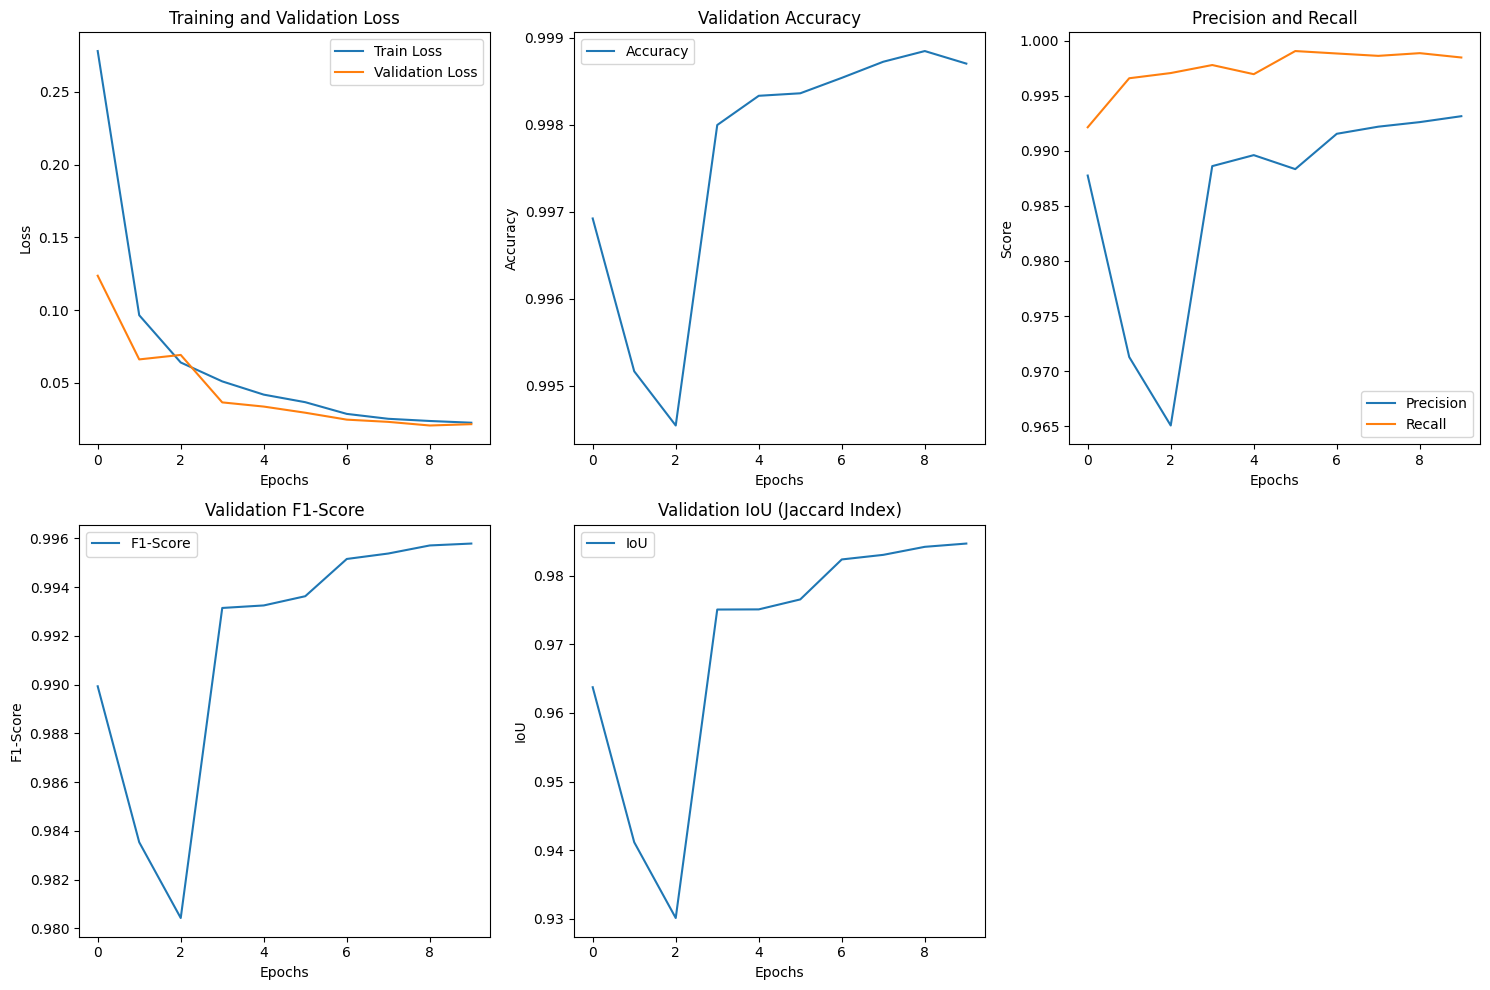

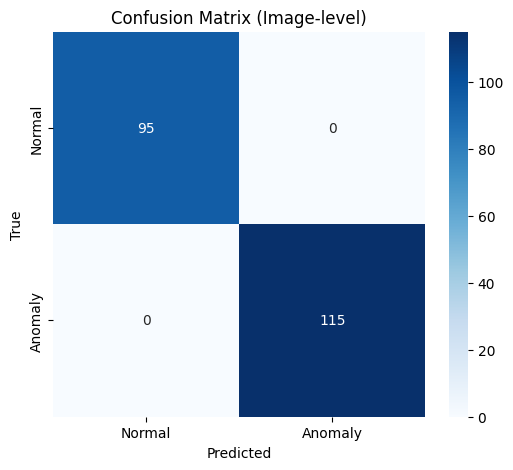

Testing on sample images...


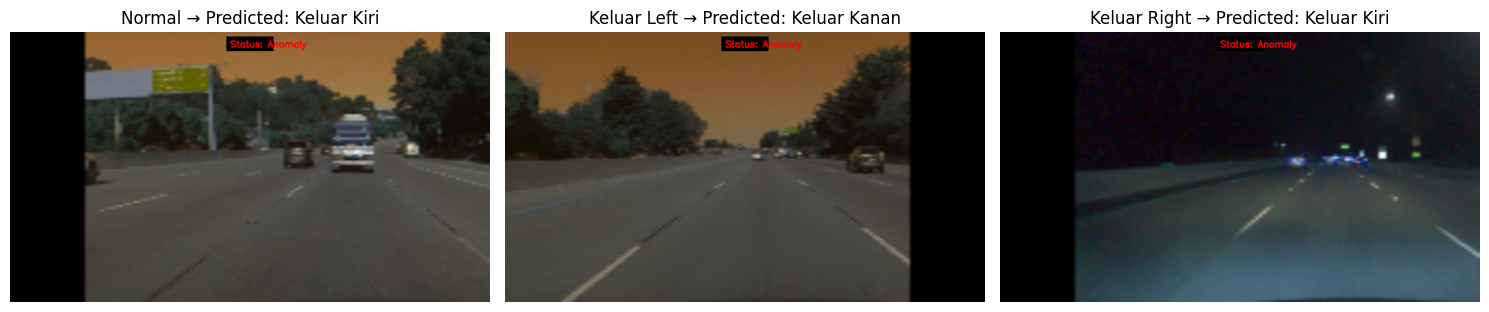

✅ All operations completed successfully!


In [44]:
import os
import json
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR

# --------------------------
# MAIN EXECUTION
# --------------------------
if __name__ == "__main__":
    DATA_DIR = '/kaggle/input/comma2k19-ld'
    OUTPUT_DIR = '/kaggle/working/preprocessed_data'
    BATCH_SIZE = 4
    EPOCHS = 10
    LR = 0.001  # Initial learning rate

    print("Starting data preprocessing...")
    metadata = preprocess_and_save(DATA_DIR, OUTPUT_DIR, max_scenes=50, max_frames=30)

    train_meta, val_meta = train_test_split(metadata, test_size=0.2, random_state=0)

    train_dataset = LaneDataset(train_meta, inject_prob=0.5)
    val_dataset = LaneDataset(val_meta, inject_prob=0.5)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    print(f"Train samples: {len(train_dataset)} | Val samples: {len(val_dataset)}")

    print("Initializing model...")
    model = LaneDetector()

    print("Initializing optimizer...")
    optimizer = optim.Adam(model.parameters(), lr=LR)

    # Learning Rate Scheduler (StepLR)
    # Apply Cosine Annealing learning rate schedule
    scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=0)  # Reduce LR by a factor of 0.5 every 5 epochs

    print("Starting training...")
    trained_model = train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, optimizer=optimizer, scheduler=scheduler)

    print("Testing on sample images...")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    trained_model.load_state_dict(torch.load('best_model.pth', map_location=device))
    trained_model.to(device)
    trained_model.eval()

    modes = ['normal', 'left', 'right']
    plt.figure(figsize=(15, 5))

    for i, mode in enumerate(modes):
        # Get random sample
        idx = np.random.choice(len(val_dataset))
        image, true_mask = val_dataset[idx]
        
        # Convert to numpy for processing
        image_np = image.permute(1, 2, 0).numpy()
        mask_np = true_mask.numpy()
        
        # Ensure proper data type
        if image_np.max() <= 1.0:
            image_np = (image_np * 255).astype(np.uint8)
        else:
            image_np = image_np.astype(np.uint8)
            
        if mask_np.max() <= 1.0:
            mask_np = (mask_np * 255).astype(np.uint8)
        else:
            mask_np = mask_np.astype(np.uint8)
        
        # Inject anomaly if needed
        if mode != 'normal':
            image_np, mask_np = inject_anomaly(image_np, mask_np, mode=mode, shift_pixels=20)
            title_true = f"Keluar {mode.capitalize()}"
        else:
            title_true = "Normal"
        
        # Convert back to tensor for model input
        image_tensor = torch.from_numpy(image_np).permute(2, 0, 1).float() / 255.0
        
        # Resize to model input size if needed
        if image_tensor.shape[1:] != (720, 1280):
            image_tensor = F.interpolate(image_tensor.unsqueeze(0), size=(128, 128), 
                                       mode='bilinear', align_corners=False).squeeze(0)
        
        # Run inference
        with torch.no_grad():
            pred_raw = trained_model(image_tensor.unsqueeze(0).to(device))[0].cpu()
            pred_mask = torch.sigmoid(pred_raw).numpy()
        
        # Detect anomaly
        anomaly_status = detect_anomaly(pred_mask)
        
        # Create clean visualization (original image with status text only)
        viz_img = visualize_results(image_tensor, pred_mask, status=0 if anomaly_status == "Normal" else 1)
        
        # Plot
        plt.subplot(1, 3, i + 1)
        plt.title(f"{title_true} → Predicted: {anomaly_status}")
        plt.imshow(viz_img)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('clean_anomaly_results.png', dpi=150, bbox_inches='tight')
    plt.show()

    print("\u2705 All operations completed successfully!")


In [45]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0.0
    total_iou = 0.0
    total_pixels = 0
    correct_pixels = 0
    num_batches = 0

    # Define loss function (same as used in training, assuming BCE with logits)
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            preds = model(images)  # Output shape: (B, 1, H, W) or (B, 2, H, W)
            # Compute loss
            loss = criterion(preds, masks)
            total_loss += loss.item()

            # Convert predictions to binary with sigmoid and threshold
            probs = torch.sigmoid(preds)  # Apply sigmoid to get probabilities
            preds_bin = (probs > 0.5).float()  # Binary predictions with threshold 0.5

            # Compute IoU
            intersection = (preds_bin * masks).sum(dim=(2, 3))  # Intersection
            union = (preds_bin + masks - preds_bin * masks).sum(dim=(2, 3))  # Union
            iou = (intersection + 1e-6) / (union + 1e-6)  # Avoid division by zero
            total_iou += iou.mean().item()

            # Compute pixel-wise accuracy
            total_pixels += masks.numel()  # Total number of pixels in the batch
            correct_pixels += (preds_bin == masks).sum().item()  # Correct pixel-wise predictions

            num_batches += 1

    avg_loss = total_loss / num_batches
    avg_iou = total_iou / num_batches
    pixel_acc = correct_pixels / total_pixels
    print(f"\n✅ Validation Loss: {avg_loss:.4f} | Validation IoU: {avg_iou * 100:.2f}% | Validation Accuracy: {pixel_acc * 100:.2f}%")
    return avg_loss, avg_iou, pixel_acc
    
evaluate_model(trained_model, val_loader, device)


✅ Validation Loss: 0.0208 | Validation IoU: 85.79% | Validation Accuracy: 99.19%


(0.02075258656492773, 0.8578666471085459, 0.9918679373604911)